In [52]:
import os

# Set the OpenAI API key
os.environ["OPENAI_API_KEY"] = "your_key"



import openai
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import SystemMessage, HumanMessage
from langtrace_python_sdk import langtrace

langtrace.init(api_key = 'your_key')


Initializing Langtrace SDK..
Exporting spans to Langtrace cloud..


In [ ]:
# Initialize in-memory SQLite for state persistence
memory = SqliteSaver.from_conn_string(":memory:")

# Define the agent state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    sources: List[str]
    revision_number: int
    max_revisions: int

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)



In [ ]:
# Prompts for various stages
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of a business report. \
Write an outline for the user provided topic. Include relevant notes or instructions for the sections."""

WRITER_PROMPT = """You are a report assistant tasked with writing a professional business report. \
Generate the best report possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}

Sources:
{sources}"""

REFLECTION_PROMPT = """You are a senior consultant reviewing a business report. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher tasked with providing information for writing the following business report. \
Generate a list of search queries to gather any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher tasked with providing information for making requested revisions (as outlined below). \
Generate a list of search queries to gather any relevant information. Only generate 3 queries max."""

DOCUMENT_ANALYSIS_PROMPT = """You are an assistant tasked with extracting relevant information from company documents. \
Extract all relevant details from the provided documents related to LN Consulting and the given task."""

In [ ]:
from langchain_core.pydantic_v1 import BaseModel
import json

class Queries(BaseModel):
    queries: List[str]

from tavily import TavilyClient

# Initialize the Tavily client
tavily = TavilyClient(api_key="your_key")



In [ ]:
# Function to read documents from a folder
def read_documents_from_folder(folder_path):
    documents = []
    sources = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".md"):  # You can add other file types here
            with open(os.path.join(folder_path, filename), 'r') as file:
                documents.append(file.read())
                sources.append(filename)
    return documents, sources

# Define the node functions
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    sources = state['sources'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
            if 'source' in r:
                sources.append(r['source'])
            else:
                sources.append('Unknown source')
    return {"content": content, "sources": sources}

def document_analysis_node(state: AgentState):
    # Path to the folder containing company documents
    folder_path = "company_docs"
    documents, sources = read_documents_from_folder(folder_path)
    
    # Process each document using the model
    for document in documents:
        messages = [
            SystemMessage(content=DOCUMENT_ANALYSIS_PROMPT),
            HumanMessage(content=document)
        ]
        response = model.invoke(messages)
        content = state['content'] or []
        content.append(response.content)
    
    # Combine sources from document analysis
    all_sources = state['sources'] or []
    all_sources.extend(sources)
    
    return {"content": content, "sources": all_sources}

def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    sources = "\n".join(state['sources'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content, sources=sources)
        ),
        user_message
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }

def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    sources = state['sources'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
            if 'source' in r:
                sources.append(r['source'])
            else:
                sources.append('Unknown source')
    return {"content": content, "sources": sources}

def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"



In [ ]:
# Build the state graph
builder = StateGraph(AgentState)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("document_analysis", document_analysis_node)
builder.add_node("research_critique", research_critique_node)
builder.set_entry_point("planner")
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "document_analysis")
builder.add_edge("document_analysis", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")
graph = builder.compile(checkpointer=memory)

# Set environment paths for graphviz (if needed)
os.environ["PATH"] += os.pathsep + "/opt/homebrew/opt/graphviz/bin"
os.environ["CFLAGS"] = "-I/opt/homebrew/opt/graphviz/include"
os.environ["LDFLAGS"] = "-L/opt/homebrew/opt/graphviz/lib"

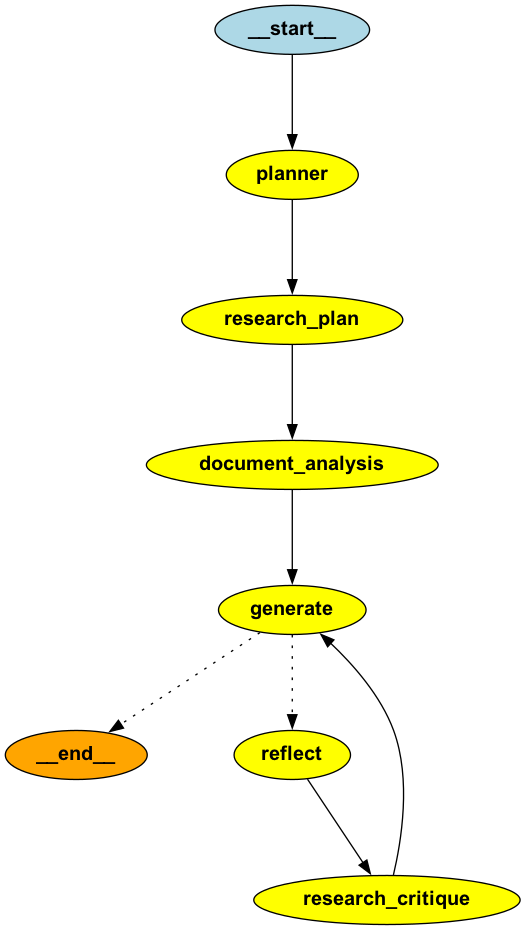

In [53]:
from IPython.display import Image

# Display the graph
Image(graph.get_graph().draw_png())



In [54]:
# Define the initial state and run the graph
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "Take-it-easy.Inc is experiencing declining sales in their main product line, \
which has been on the market for 10 years. They suspect increased competition and outdated marketing strategies. \
Their desired outcome is to revitalize sales and regain market share within the next 6 months. \
They are open to exploring new marketing channels. Generate a 2-page sample report in markdown format, \
with a teaser of possible solutions and how LN Consulting can deliver, listing LN Consulting's relevant case studies, search links, names of documents. Save it as sample.report.txt",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)


Exported 14 spans successfully.
{'planner': {'plan': '# Business Report: Revitalizing Sales Strategy for Take-it-easy.Inc\n\n## Executive Summary\n- Overview of declining sales in main product line\n- Suspected causes: increased competition, outdated marketing strategies\n- Desired outcome: Revitalize sales and regain market share within 6 months\n- Open to exploring new marketing channels\n\n## Introduction\n- Background of Take-it-easy.Inc\n- Importance of addressing declining sales\n- Purpose of the report\n\n## Current Situation Analysis\n- Sales data analysis for the past 2 years\n- Market trends and competition analysis\n- Evaluation of current marketing strategies\n\n## Possible Solutions\n- Introduction to new marketing channels\n- Implementing digital marketing strategies\n- Enhancing product positioning and branding\n- Improving customer engagement and loyalty programs\n\n## Proposed Action Plan\n- Short-term and long-term strategies\n- Timeline for implementation\n- Key perf

In [55]:
import json

# Convert the object 's' to a valid JSON string
s_json = json.dumps(s)

# Convert JSON string to Python dict
data = json.loads(s_json)

# Access the 'draft' value from the last 'generate' object
draft_text = data['generate']['draft']

# Print the draft value with markdown formatting
print(f"### Draft:\n\n```markdown\n{draft_text}\n```")


### Draft:

```markdown
# Business Report: Revitalizing Sales Strategy for Take-it-easy.Inc

## Executive Summary
- **Overview:** Take-it-easy.Inc is facing declining sales in their main product line, potentially due to increased competition and outdated marketing strategies.
- **Desired Outcome:** The goal is to revitalize sales and regain market share within the next 6 months by exploring new marketing channels.
- **Approach:** LN Consulting offers expertise in revitalizing sales strategies and can provide tailored solutions to address the challenges faced by Take-it-easy.Inc.

## Introduction
Take-it-easy.Inc, a company with a decade-long presence in the market, is currently experiencing a decline in sales in their main product line. This report aims to analyze the root causes of this decline and propose strategies to revitalize sales and regain market share swiftly.

## Current Situation Analysis
- **Sales Data Analysis:** A detailed examination of sales data from the past 2 years 

In [70]:
import json

# Convert the object 's' to a valid JSON string
s_json = json.dumps(s)

# Convert JSON string to Python dict
data = json.loads(s_json)

# Function to print the content of each section
def print_section(title, content):
    print(f"\n### {title}:\n")
    print(json.dumps(content, indent=2))

# Check and print each section if it exists
if 'planner' in data:
    print_section('Planner', data['planner'])

if 'research_plan' in data:
    print_section('Research Plan', data['research_plan'])

if 'document_analysis' in data:
    print_section('Document Analysis', data['document_analysis'])

if 'generate' in data:
    print_section('Generate', data['generate'])

if 'reflect' in data:
    print_section('Reflect', data['reflect'])

if 'research_critique' in data:
    print_section('Research Critique', data['research_critique'])



### Generate:

{
  "draft": "# Business Report: Revitalizing Sales Strategy for Take-it-easy.Inc\n\n## Executive Summary\n- **Overview:** Take-it-easy.Inc is facing declining sales in their main product line, potentially due to increased competition and outdated marketing strategies.\n- **Desired Outcome:** The goal is to revitalize sales and regain market share within the next 6 months by exploring new marketing channels.\n- **Approach:** LN Consulting offers expertise in revitalizing sales strategies and can provide tailored solutions to address the challenges faced by Take-it-easy.Inc.\n\n## Introduction\nTake-it-easy.Inc, a company with a decade-long presence in the market, is currently experiencing a decline in sales in their main product line. This report aims to analyze the root causes of this decline and propose strategies to revitalize sales and regain market share swiftly.\n\n## Current Situation Analysis\n- **Sales Data Analysis:** A detailed examination of sales data from 